# Dependencies

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 1.9 MB 5.4 MB/s 


# Helper functions

In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.xlabel("time s")
    plt.ylabel("amplitude")
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        pxx,  freq, t, cax = axes[c].specgram(waveform[c], Fs=sample_rate)
        figure.colorbar(cax)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.xlabel("time s")
    plt.ylabel("frequency Hz")
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError(
            "Waveform with more than 2 channels are not supported.")

In [ ]:
def vocabulary_df(*datasets):
    def u2df(utterance):
        return pd.DataFrame(utterance.split(" "), columns=["word"])
    
    def d2df(dataset):
        # (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
        return pd.concat([u2df(data[2]) for data in iter(dataset)], ignore_index=True)

    return pd.concat([d2df(dataset) for dataset in datasets], ignore_index=True)

# Compare dataset splits

Each part of the dataset can be downloaded separately by name. The available parts are  "dev-clean", "dev-other", "test-clean", "test-other", "train-clean-100", "train-clean-360" and "train-other-500". After the download the archives are not deleted, so this can be performed manually. The dataset downloading stage takes around 30 minutes. You can comment the parts that are not useful for the task. Maybe skip the train-500 dataset since it fills the disk.

In [ ]:
import torchaudio.datasets

In [ ]:
# "dev-clean", "dev-other", "test-clean", "test-other", "train-clean-100", "train-clean-360" and "train-other-500"
# train_500 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-other-500", folder_in_archive="LibriSpeech", download=True)
# %rm -rf *.tar.gz # clean up archives
train_360 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-clean-360", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives
train_100 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-clean-100", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives
test_clean = torchaudio.datasets.LIBRISPEECH(root=".", url="test-clean", folder_in_archive="LibriSpeech", download=True)
test_other = torchaudio.datasets.LIBRISPEECH(root=".", url="test-other", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives
dev_clean = torchaudio.datasets.LIBRISPEECH(root=".", url="dev-clean", folder_in_archive="LibriSpeech", download=True)
dev_other = torchaudio.datasets.LIBRISPEECH(root=".", url="dev-other", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives

In [ ]:
import pandas as pd

In [ ]:
# Create a dataframe containing the words from multiple parts
test_df = vocabulary_df(test_clean, test_other)
dev_df = vocabulary_df(dev_clean, dev_other)
train_100_df = vocabulary_df(train_100)
train_360_df = vocabulary_df(train_360)

In [ ]:
# Create a dataframe containing the number of unique words for each part
# First option - largest datasets
df1 = test_df.agg("nunique").append([train_100_df.agg("nunique"), train_360_df.agg("nunique")], ignore_index=True)
df1 = pd.DataFrame(df1, columns=["words"])
df1["part"] = ["test", "val", "train"]
df1 = df1.set_index("part")

# Second option - smallest datasets
df2 = test_df.agg("nunique").append([dev_df.agg("nunique"), train_100_df.agg("nunique")], ignore_index=True)
df2 = pd.DataFrame(df2, columns=["words"])
df2["part"] = ["test", "val", "train"]
df2 = df2.set_index("part")

# Third option - combination of both
df3 = test_df.agg("nunique").append([dev_df.agg("nunique"), train_360_df.agg("nunique")], ignore_index=True)
df3 = pd.DataFrame(df3, columns=["words"])
df3["part"] = ["test", "val", "train"]
df3 = df3.set_index("part")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

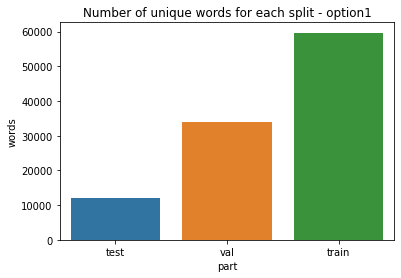

In [ ]:
bar = sns.barplot(x=df1.index, y="words", data=df1)
bar.set_title("Number of unique words for each split - option1")
plt.show()

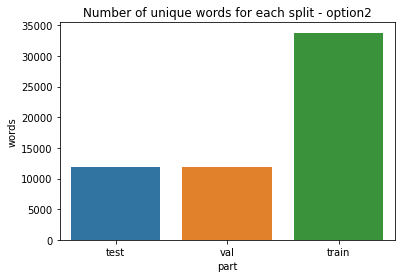

In [ ]:
bar = sns.barplot(x=df2.index, y="words", data=df2)
bar.set_title("Number of unique words for each split - option2")
plt.show()

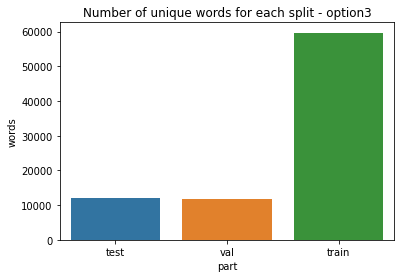

In [ ]:
bar = sns.barplot(x=df3.index, y="words", data=df3)
bar.set_title("Number of unique words for each split - option3")
plt.show()

In [ ]:
import numpy as np

In [ ]:
# get the unique words as np.ndarray
test_words = test_df["word"].unique()
dev_words = dev_df["word"].unique()
train_100_words = train_100_df["word"].unique()
train_360_words = train_360_df["word"].unique()

In [ ]:
# how many test words are new compared to the training dataset
diff = np.setdiff1d(test_words, train_360_words, assume_unique=True)
print(f'test-train: {diff.size}')

test-train: 942


In [ ]:
# how many test words are new compared to the training dataset
diff = np.setdiff1d(test_words, train_100_words, assume_unique=True)
print(f'test-train: {diff.size}')

test-train: 1884


# Analyze dataset vocabulary

In [ ]:
# TODO

# Analyze dataset audio

In [ ]:
import torchaudio.datasets
import random

In [ ]:
# download dataset parts
dev_clean = torchaudio.datasets.LIBRISPEECH(root=".", url="dev-clean", folder_in_archive="LibriSpeech", download=True)
dev_other = torchaudio.datasets.LIBRISPEECH(root=".", url="dev-other", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives

Sample Rate: 16000
Shape: (1, 73600)
Dtype: torch.float32
 - Max:      0.316
 - Min:     -0.248
 - Mean:    -0.000
 - Std Dev:  0.040

tensor([[ 0.0004,  0.0001,  0.0002,  ..., -0.0029, -0.0040, -0.0039]])



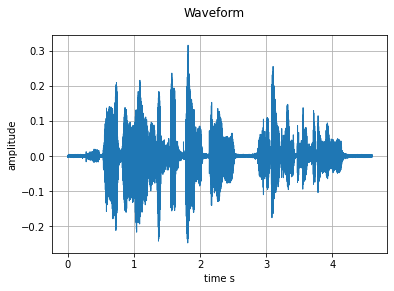

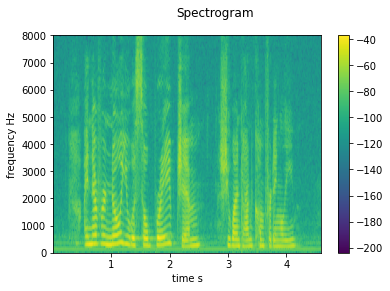

In [ ]:
# print stats for a random audio sample from the dev-clean part
waveform, sample_rate, _, _, _, _ = random.choice(dev_clean)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [ ]:
import torch.nn as nn
import torchaudio
import pandas as pd
import glob
import os

In [ ]:
# use glob to read all the paths to audio files
dev_clean_paths = glob.glob(os.path.join("LibriSpeech", "dev-clean", "**", "**", "*.flac"))
dev_other_paths = glob.glob(os.path.join("LibriSpeech", "dev-other", "**", "**", "*.flac"))

In [ ]:
# get metadata for each audio file
dev_clean_meta = [torchaudio.info(path).__dict__ for path in dev_clean_paths]
dev_other_meta = [torchaudio.info(path).__dict__ for path in dev_other_paths]

In [ ]:
# convert the metadata to dataframes
dev_clean_df = pd.DataFrame(dev_clean_meta)
dev_other_df = pd.DataFrame(dev_other_meta)

In [ ]:
dev_clean_df.head()

,sample_rate,num_frames,num_channels,bits_per_sample,encoding
0,16000,129120,1,16,FLAC
1,16000,63680,1,16,FLAC
2,16000,43680,1,16,FLAC
3,16000,49360,1,16,FLAC
4,16000,57200,1,16,FLAC


In [ ]:
dev_clean_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,2703.0,2703.000000,2703.0,2703.0
mean,16000.0,114812.405475,1.0,16.0
std,0.0,75129.797618,0.0,0.0
min,16000.0,23120.000000,1.0,16.0
25%,16000.0,60160.000000,1.0,16.0
50%,16000.0,94720.000000,1.0,16.0
75%,16000.0,148280.000000,1.0,16.0
max,16000.0,522320.000000,1.0,16.0


In [ ]:
dev_other_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,2864.0,2864.000000,2864.0,2864.0
mean,16000.0,102995.895950,1.0,16.0
std,0.0,69093.834962,0.0,0.0
min,16000.0,17040.000000,1.0,16.0
25%,16000.0,55440.000000,1.0,16.0
50%,16000.0,84040.000000,1.0,16.0
75%,16000.0,126660.000000,1.0,16.0
max,16000.0,562480.000000,1.0,16.0


We can see that the sample rate for the clean and test samples is equal to 16K, the number of frames differs, having a mean of ~110K frames with a standard deviation of ~70K frames. The number of channels used for this dataset is 1 and the bits_per_sample is 16.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cdf = dev_clean_df["num_frames"].value_counts().sort_index()
odf = dev_other_df["num_frames"].value_counts().sort_index()

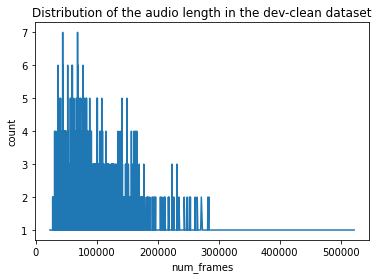

In [ ]:
plot = sns.lineplot(data=cdf)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the dev-clean dataset")
plt.show()

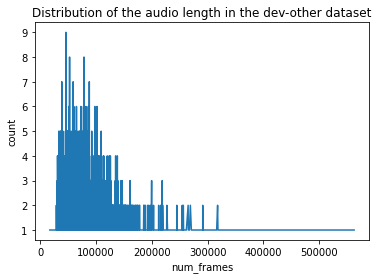

In [ ]:
plot = sns.lineplot(data=odf)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the dev-other dataset")
plt.show()

# Analyze dataset audio - large parts

In [ ]:
import torchaudio.datasets

In [ ]:
# "dev-clean", "dev-other", "test-clean", "test-other", "train-clean-100", "train-clean-360" and "train-other-500"
# train_500 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-other-500", folder_in_archive="LibriSpeech", download=True)
# %rm -rf *.tar.gz # clean up archives
train_360 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-clean-360", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives
train_100 = torchaudio.datasets.LIBRISPEECH(root=".", url="train-clean-100", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives
test_clean = torchaudio.datasets.LIBRISPEECH(root=".", url="test-clean", folder_in_archive="LibriSpeech", download=True)
test_other = torchaudio.datasets.LIBRISPEECH(root=".", url="test-other", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives

In [ ]:
import torch.nn as nn
import torchaudio
import pandas as pd
import glob
import os

In [ ]:
train_360_paths = glob.glob(os.path.join("LibriSpeech", "train-clean-360", "**", "**", "*.flac"))
train_100_paths = glob.glob(os.path.join("LibriSpeech", "train-clean-100", "**", "**", "*.flac"))
test_clean_paths = glob.glob(os.path.join("LibriSpeech", "test-clean", "**", "**", "*.flac"))
test_other_paths = glob.glob(os.path.join("LibriSpeech", "test-other", "**", "**", "*.flac"))

In [ ]:
train_360_meta = [torchaudio.info(path).__dict__ for path in train_360_paths]
train_100_meta = [torchaudio.info(path).__dict__ for path in train_100_paths]
test_clean_meta = [torchaudio.info(path).__dict__ for path in test_clean_paths]
test_other_meta = [torchaudio.info(path).__dict__ for path in test_other_paths]

In [ ]:
# convert the metadata to dataframes
train_360_df = pd.DataFrame(train_360_meta)
train_100_df = pd.DataFrame(train_100_meta)
test_clean_df = pd.DataFrame(test_clean_meta)
test_other_df = pd.DataFrame(test_other_meta)

In [ ]:
train_360_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,104014.0,104014.000000,104014.0,104014.0
mean,16000.0,201354.462332,1.0,16.0
std,0.0,58093.451624,0.0,0.0
min,16000.0,17040.000000,1.0,16.0
25%,16000.0,182160.000000,1.0,16.0
50%,16000.0,222880.000000,1.0,16.0
75%,16000.0,242240.000000,1.0,16.0
max,16000.0,475760.000000,1.0,16.0


In [ ]:
train_100_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,28539.0,28539.000000,28539.0,28539.0
mean,16000.0,203021.642945,1.0,16.0
std,0.0,57194.454790,0.0,0.0
min,16000.0,22560.000000,1.0,16.0
25%,16000.0,185920.000000,1.0,16.0
50%,16000.0,223920.000000,1.0,16.0
75%,16000.0,242640.000000,1.0,16.0
max,16000.0,392400.000000,1.0,16.0


In [ ]:
test_clean_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,2620.0,2620.000000,2620.0,2620.0
mean,16000.0,118793.774809,1.0,16.0
std,0.0,82467.680265,0.0,0.0
min,16000.0,20560.000000,1.0,16.0
25%,16000.0,58860.000000,1.0,16.0
50%,16000.0,92640.000000,1.0,16.0
75%,16000.0,153620.000000,1.0,16.0
max,16000.0,559280.000000,1.0,16.0


In [ ]:
test_other_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample
count,2939.0,2939.000000,2939.0,2939.0
mean,16000.0,104686.329364,1.0,16.0
std,0.0,70833.603469,0.0,0.0
min,16000.0,20000.000000,1.0,16.0
25%,16000.0,54599.500000,1.0,16.0
50%,16000.0,82400.000000,1.0,16.0
75%,16000.0,131440.000000,1.0,16.0
max,16000.0,552160.000000,1.0,16.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
t360df = train_360_df["num_frames"].value_counts().sort_index()
t100df = train_100_df["num_frames"].value_counts().sort_index()
tcdf = test_clean_df["num_frames"].value_counts().sort_index()
todf = test_other_df["num_frames"].value_counts().sort_index()

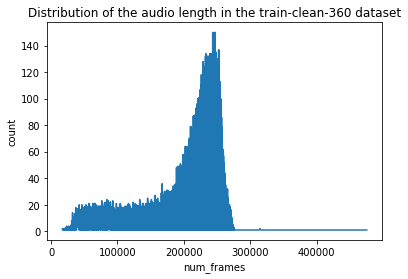

In [ ]:
plot = sns.lineplot(data=t360df)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the train-clean-360 dataset")
plt.show()

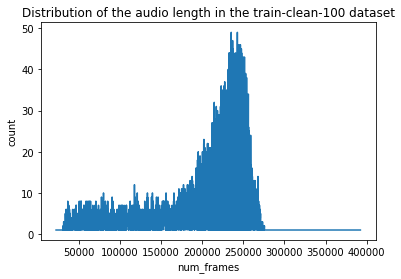

In [ ]:
plot = sns.lineplot(data=t100df)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the train-clean-100 dataset")
plt.show()

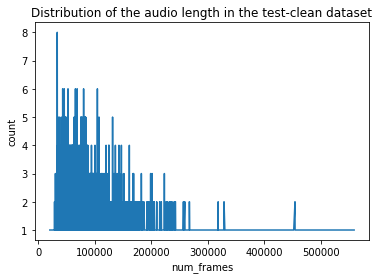

In [ ]:
plot = sns.lineplot(data=tcdf)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the test-clean dataset")
plt.show()

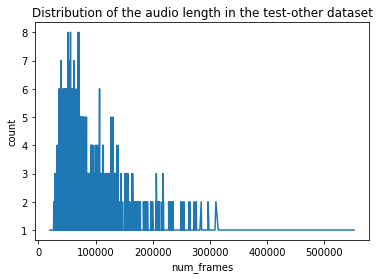

In [ ]:
plot = sns.lineplot(data=todf)
plot.set_xlabel("num_frames")
plot.set_ylabel("count")
plot.set_title("Distribution of the audio length in the test-other dataset")
plt.show()

# Analyze speakers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torchaudio.datasets

In [ ]:
dev_clean = torchaudio.datasets.LIBRISPEECH(root=".", url="dev-clean", folder_in_archive="LibriSpeech", download=True)
%rm -rf *.tar.gz # clean up archives

In [ ]:
speakers = pd.read_table(os.path.join("LibriSpeech", "SPEAKERS.TXT"), 
                         delimiter="|", comment=";", 
                         header=None, names=["ID", "SEX", "SUBSET", "MINUTES", "NAME"], 
                         converters={"ID": str.strip, "SEX": str.strip, "SUBSET": str.strip, "MINUTES": float, "NAME": str.strip})

In [ ]:
speakers.head()

,ID,SEX,SUBSET,MINUTES,NAME
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


In [ ]:
dev_clean = speakers.loc[speakers["SUBSET"] == "dev-clean"]
dev_other = speakers.loc[speakers["SUBSET"] == "dev-other"]
test_clean = speakers.loc[speakers["SUBSET"] == "test-clean"]
test_other = speakers.loc[speakers["SUBSET"] == "test-other"]

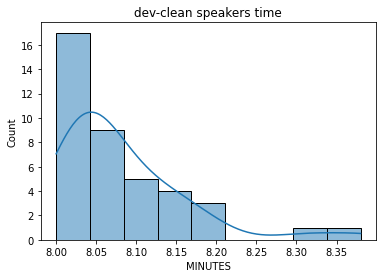

In [ ]:
hist = sns.histplot(dev_clean["MINUTES"], kde=True)
hist.set_title("dev-clean speakers time")
plt.show()

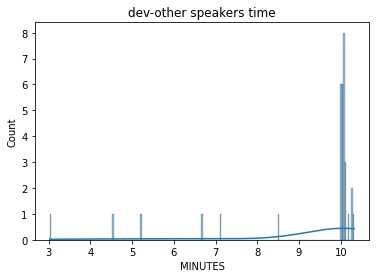

In [ ]:
hist = sns.histplot(dev_other["MINUTES"], kde=True)
hist.set_title("dev-other speakers time")
plt.show()

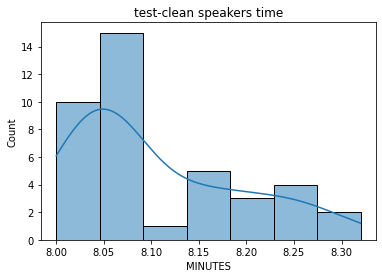

In [ ]:
hist = sns.histplot(test_clean["MINUTES"], kde=True)
hist.set_title("test-clean speakers time")
plt.show()

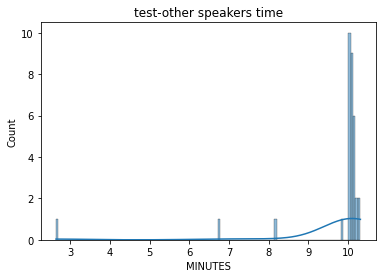

In [ ]:
hist = sns.histplot(test_other["MINUTES"], kde=True)
hist.set_title("test-other speakers time")
plt.show()